<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/dev_files/time_series_collab_notebook_arthur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade statsmodels

     |████████████████████████████████| 9.8 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# !pip3 install darts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from datetime import datetime
from pathlib import Path
import sys
import os
import shutil
import joblib
tqdm.pandas()

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam

# from darts import TimeSeries
# from darts.models import (
#     NaiveSeasonal,
#     NaiveDrift,
#     Prophet,
#     ExponentialSmoothing,
#     ARIMA,
#     AutoARIMA,
#     RegressionEnsembleModel,
#     RegressionModel,
#     Theta,
#     FFT
# )

# from darts.metrics import mape, mase
# from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
# from darts.datasets import AirPassengersDataset

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)

# from google.colab import drive
# drive.mount('drive/')

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# gpu ?
from torch import cuda
if cuda.is_available():
    print("GPU")
    print(f"device name: {cuda.get_device_name()}")
    print(f"memory: {int(round(cuda.get_device_properties(0).total_memory / 1024 ** 2, 0))} MB")
else:
    print("CPU")

GPU
device name: Tesla K80
memory: 11441 MB


In [ ]:
path_github_repo = Path.cwd() / "time_series_project_simplon"
if path_github_repo.is_dir():
    shutil.rmtree(path_github_repo)

!git clone https://github.com/tjohanne42/time_series_project_simplon.git

from time_series_project_simplon.utils.functions import generate_df_by_time_section

Cloning into 'time_series_project_simplon'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 151 (delta 58), reused 84 (delta 27), pack-reused 0
Receiving objects: 100% (151/151), 12.95 MiB | 1.43 MiB/s, done.
Resolving deltas: 100% (58/58), done.


# import dataset

weekly nuclear production of energy

In [ ]:
!dir

drive  sample_data  time_series_project_simplon


In [ ]:
df_day = generate_df_by_time_section(time_section="day", verbose=True)
df_day

replace outliers in 'solar' values with interpolation ...
set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01,2.448325e+06,2.029537e+06,7.603880e+05,226484.000000,0.000000
1,2012-01-02,2.938653e+06,2.037884e+06,7.955313e+05,224000.780488,0.000000
2,2012-01-03,4.430877e+06,2.005847e+06,6.219160e+05,231623.000000,0.000000
3,2012-01-04,4.903744e+06,2.039013e+06,7.644070e+05,232221.000000,0.000000
4,2012-01-05,4.765032e+06,2.171748e+06,7.601810e+05,238301.000000,0.000000
...,...,...,...,...,...,...
2767,2019-07-30,0.000000e+00,1.573999e+06,1.233718e+06,73637.000000,376435.335097
2768,2019-07-31,0.000000e+00,1.606865e+06,1.685585e+06,92945.000000,355390.763997
2769,2019-08-01,0.000000e+00,1.606940e+06,6.505120e+05,117124.000000,519328.582901
2770,2019-08-02,0.000000e+00,1.592180e+06,2.959050e+05,115334.000000,596295.099905


In [ ]:
df_coal_day = df_day[["timestamp", "coal"]]
df_coal_day

,timestamp,coal
0,2012-01-01,2.448325e+06
1,2012-01-02,2.938653e+06
2,2012-01-03,4.430877e+06
3,2012-01-04,4.903744e+06
4,2012-01-05,4.765032e+06
...,...,...
2767,2019-07-30,0.000000e+00
2768,2019-07-31,0.000000e+00
2769,2019-08-01,0.000000e+00
2770,2019-08-02,0.000000e+00


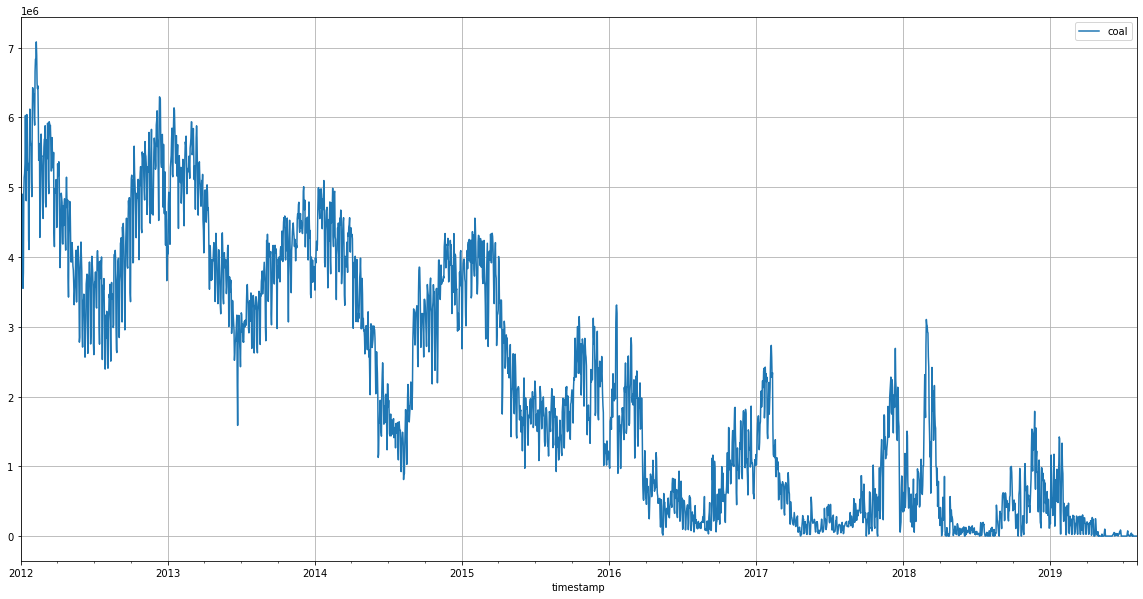

In [ ]:
df_coal_day.set_index(keys="timestamp").plot(figsize=(20,10), grid=True)

# LSTM (with Time Series Generator)

- LSTM activation -> Sigmoid, tanh
- activation = "tanh", recurrent
- learning rate = 0.001, adam optimizer
- adaptive learning rates ? (Learning Rate Schedules, ReduceLROnPlateau)
- train, val, test set
- LSTM, dense, dropout layers
- Relu, leaky Relu, P Relu activation functions
- N input timestamps, M output timestamps

## train, validation, test sets

train (split_1) validation (split_2) test

In [ ]:
index_split_1 = round(len(df_nuclear_week) * 0.7)
index_split_2 = round(len(df_nuclear_week) * 0.8)

train = df_nuclear_week.iloc[:index_split_1, 1].values.reshape(-1, 1)
val = df_nuclear_week.iloc[index_split_1:index_split_2, 1].values.reshape(-1, 1)
test = df_nuclear_week.iloc[index_split_2:, 1].values.reshape(-1, 1)

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

## MinMax scaling

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(scaled_train.min(), scaled_train.max())

In [ ]:
print(train.shape, scaled_train.shape)

In [ ]:
# train
# scaler.inverse_transform(scaled_test)
# np.hstack([train, scaler.inverse_transform(scaled_train)])

In [ ]:
np.array_equal(train, scaler.inverse_transform(scaled_train))
# false but close enough

## Time series Generator

generates 2 objects x and y:<br>
x is the list the "input_length" last values of the time series,<br>
y is the next value.

In [ ]:
input_length = 24
features_length = 1
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=input_length, batch_size=batch_size)

# we need to add the last "input_length" values of scaled train to scaled_val,
# to create a generator of the right length
# print(scaled_train[-input_length:].shape, scaled_val.shape)
scaled_val_for_generator = np.vstack([scaled_train[-input_length:], scaled_val])
# scaled_val_for_generator.shape
val_generator = TimeseriesGenerator(scaled_val_for_generator, scaled_val_for_generator, length=input_length, batch_size=batch_size)

In [ ]:
x, y = train_generator[3]
# print(x)
# print(y)

In [ ]:
len(train_generator), len(val_generator)

In [ ]:
print(x.shape)
print(y.shape)

x (input) shape = (batch size, input length, features length)<br>
y (expected output) shape = (batch size, output length)

## create a model

In [ ]:
LSTM?

In [ ]:
# inputs = Input(shape=(input_length, features_length))

# # main = Dense(n_lag, activation="relu")(inputs)
# main = LSTM(256, activation="tanh", return_sequences=True)(inputs)
# main = LSTM(128, activation="tanh", return_sequences=True)(main)
# main = LSTM(64, activation="tanh")(main)
# # main = Dense(64, activation="relu")(main)
# main = Dense(1, activation="relu", name='output')(main)

# model = Model(inputs, main)

# model.summary()
# plot_model(model, to_file="model.png", show_shapes=True)

# model.compile(
#   optimizer = Adam(learning_rate=0.001),
# #   optimizer = RMSprop(learning_rate=0.001),
#   loss = "mse",
# )

model = Sequential()

model.add(Input(shape=(input_length, features_length), name="input"))

model.add(LSTM(256, activation="tanh", return_sequences=True, name="LSTM_256"))
model.add(LSTM(128, activation="tanh", return_sequences=True, name="LSTM_128"))
model.add(LSTM(64, activation="tanh", name="LSTM_64"))

model.add(Dense(1, activation="relu", name='output'))

model.compile(
  optimizer = Adam(learning_rate=0.0001),
#   optimizer = RMSprop(learning_rate=0.001),
  loss = "mse"
)

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, rankdir="TB")

## train the model

- checkpoints during training
- add logs
- save checkpoints and logs on google drive

In [ ]:
# remove previous checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
root, _, ckpts = next(os.walk(path_models / "weights_checkpoints"))
for ckpt in ckpts:
    os.remove(Path(root) / ckpt)

In [ ]:
# model_checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "my_model"

history = model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    epochs=10,
    verbose=2,
    callbacks=[
        TqdmCallback(verbose=2),
        EarlyStopping(monitor='loss', patience=3),
        ModelCheckpoint(filepath=path_models / "weights_checkpoints" / "weights_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.hdf5",
                        verbose=0, save_best_only=False,
                        save_weights_only=True, mode='auto', save_freq='epoch',
                        options=None)
    ],
    # workers=-1,
    # use_multiprocessing=True
)

# save model
model.save(path_models / model_name)

# save fit history
joblib.dump(history.history, path_models / model_name / "fit_history.pkl")

# save model png representation
path_model_png_file = Path.cwd().resolve() / "drive" / "MyDrive" / "time_series_models" / model_name / "model.png"
plot_model(model, to_file=str(path_model_png_file), show_shapes=True, rankdir="TB")

# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(history.history["loss"])), history.history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
# model.fit?

## test the model


In [ ]:
# load model
model_dir_path = Path.cwd() / "saved_models"
loaded_model = keras.models.load_model(model_dir_path / "my_model")

# load fit history
fit_history = joblib.load(model_dir_path / "my_model" / "fit_history.pkl")

In [ ]:
# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(fit_history["loss"])), fit_history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(fit_history["val_loss"])), fit_history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
# scaled_train

In [ ]:
# test_predictions must be of shape (len(df_test), 1) to
# be passed to scaler.inverse_transform
test_predictions = np.array([]).reshape((0,1))
first_batch_for_prediction = scaled_train[-input_length:].copy()
current_batch = first_batch_for_prediction.reshape((1, input_length, features_length))
# print(current_batch)

df_test = df_nuclear_week.iloc[index_split_2:, :].copy().set_index(keys="timestamp")
df_test

# model.predict(current_batch).shape

for index in tqdm(range(len(df_test))):
    # print()
    # print(current_batch)
    current_prediction = model.predict(current_batch)
    # print(current_prediction[0,0])
    # test_predictions.append(current_prediction)
    test_predictions = np.vstack((test_predictions, current_prediction))
    current_batch[0, :-1, 0] = current_batch[0, 1:, 0]
    current_batch[0, -1, 0] = current_prediction[0,0]
    # print(current_batch)
    # break
# print(test_predictions)

test_predictions_unnormalized = scaler.inverse_transform(test_predictions)
test_predictions_unnormalized

df_test["prediction"] = test_predictions_unnormalized
# df_test

# print(test_predictions_unnormalized)
df_test.plot(figsize=(14,5))

# LSTM (with nlag outputs)

In [ ]:
df_full = generate_df_by_time_section(time_section="day", verbose=True)

replace outliers in 'solar' values with interpolation ...
set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


In [ ]:
df = df_full[["timestamp", "nuclear"]].copy()
df

,timestamp,nuclear
0,2012-01-01,2.029537e+06
1,2012-01-02,2.037884e+06
2,2012-01-03,2.005847e+06
3,2012-01-04,2.039013e+06
4,2012-01-05,2.171748e+06
...,...,...
2767,2019-07-30,1.573999e+06
2768,2019-07-31,1.606865e+06
2769,2019-08-01,1.606940e+06
2770,2019-08-02,1.592180e+06


## train, test sets

In [ ]:
index_split = int(round(len(df) * 0.70))

df_train = df.iloc[:index_split, :].copy()
df_test = df.iloc[index_split:, :].copy()

train = df_train["nuclear"].values.reshape(-1,1)
test = df_test["nuclear"].values.reshape(-1,1)

In [ ]:
print(len(train), len(test))

1940 832


## MinMax scaling

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
print(scaled_train.min(), scaled_train.max())

0.0 0.9999999999999999


## (input_length -> output_length) generator

In [ ]:
input_length = 30
features_length = 1
output_length = 30

# X_train.shape = (n_examples, input_length)
# y_train.shape = (n_examples, output_length)
X_train = np.array([]).reshape((0, input_length))
y_train = np.array([]).reshape((0, output_length))

for example_index in tqdm(range(0, len(scaled_train) - input_length - output_length), desc="example index"):
    # print(example_index + input_length + output_length)
    X_train = np.vstack([X_train, scaled_train.flatten()[example_index                : example_index + input_length                ]])
    y_train = np.vstack([y_train, scaled_train.flatten()[example_index + input_length : example_index + input_length + output_length]])

# change X_train shape from (number of examples, input_length) to (number of examples, input_length, features_length)
X_train = X_train.reshape((-1, input_length, 1))

example index:   0%|          | 0/1880 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape, y_train.shape)

(1880, 30, 1) (1880, 30)


## create a model

In [ ]:
LSTM?

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30, 30)            60        
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 256)           293888    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 30)                1950      
Total params: 1,067,738
Trainable params: 1,067,738
Non-trainable params: 0
____________________________________________

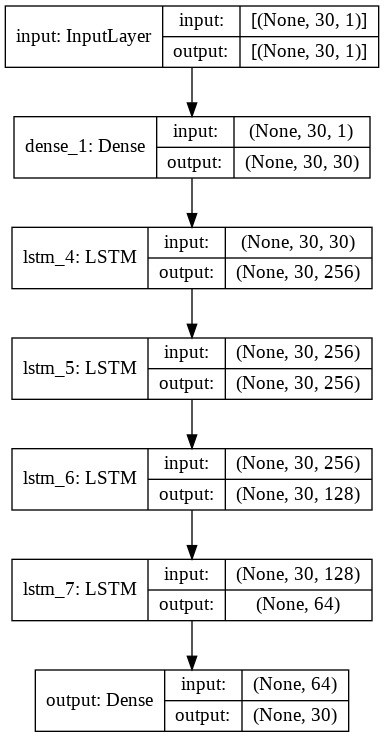

In [ ]:
batch_size = 16

model = Sequential()

model.add(Input(shape=(input_length, features_length), name="input"))
# model.add(Input(batch_input_shape=(batch_size, input_length, features_length), name="input"))
# model.add(Input(shape=(input_length, features_length), batch_size=batch_size, name="input"))

# model.add(LSTM(output_length, activation="tanh", name="LSTM"))
# model.add(Dense(output_length))

model.add(Dense(input_length, activation="relu"))
model.add(LSTM(256, activation="tanh", return_sequences=True))
model.add(LSTM(256, activation="tanh", return_sequences=True))
model.add(LSTM(128, activation="tanh", return_sequences=True))
# model.add(Dropout(.2))
model.add(LSTM(64, activation="tanh"))
# model.add(Dropout(.2))
model.add(Dense(output_length, activation=None, name='output'))

# model.add(LSTM(64, activation="tanh", name="LSTM"))
# model.add(Dense(output_length, activation="relu", name='dense_output'))

# model.add(LSTM(120, activation="tanh", stateful=True, name="LSTM"))
# model.add(Dense(output_length, activation="relu", name='dense_output'))

# model.add(LSTM(output_length, activation="tanh", stateful=True, name="LSTM"))

# model.add(LSTM(256, activation="tanh", return_sequences=True, name="LSTM_256"))
# model.add(LSTM(128, activation="tanh", return_sequences=True, name="LSTM_128"))
# model.add(LSTM(64, activation="tanh", name="LSTM_64"))
# model.add(Dense(1, activation="relu", name='output'))

# main = Dense(n_lag, activation="relu")(inputs)
# main = LSTM(256, activation="relu", return_sequences=True)(main)
# main = LSTM(128, activation="relu", return_sequences=True)(main)
# main = LSTM(64, activation="relu")(main)
# main = Dense(n_lag, activation=None, name='output')(main)

model.compile(
    optimizer = Adam(learning_rate=1e-3),
    # optimizer = RMSprop(learning_rate=0.001),
    # loss = "mean_squared_error",
    # loss = "mean_absolute_error",
    loss = "mae",
)

model.summary()
# plot_model(model, to_file="model.png", show_shapes=True, rankdir="TB")
plot_model(model, show_shapes=True, rankdir="TB")

## train the model

In [ ]:
# remove previous checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
root, _, ckpts = next(os.walk(path_models / "weights_checkpoints"))
for ckpt in ckpts:
    os.remove(Path(root) / ckpt)

In [ ]:
# load a specific checkpoint
path_model_ckpts = Path.cwd() / "drive" / "MyDrive" / "time_series_models" / "weights_checkpoints"
ckpt_name = "weights_epoch_003_loss_0.1268_val_loss_0.1256.hdf5"
model.load_weights(filepath=str(path_model_ckpts / ckpt_name))

In [ ]:
model.fit?

0epoch [00:00, ?epoch/s]

Epoch 1/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 16s - loss: 0.1764 - val_loss: 0.0964
Epoch 2/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1438 - val_loss: 0.0955
Epoch 3/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1419 - val_loss: 0.0951
Epoch 4/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1407 - val_loss: 0.0951
Epoch 5/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1401 - val_loss: 0.0952
Epoch 6/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1396 - val_loss: 0.0953
Epoch 7/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1392 - val_loss: 0.0953
Epoch 8/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1389 - val_loss: 0.0955
Epoch 9/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1386 - val_loss: 0.0957
Epoch 10/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1383 - val_loss: 0.0959
Epoch 11/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1381 - val_loss: 0.0960
Epoch 12/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1379 - val_loss: 0.0962
Epoch 13/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1377 - val_loss: 0.0966
Epoch 14/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1375 - val_loss: 0.0969
Epoch 15/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1374 - val_loss: 0.0971
Epoch 16/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1373 - val_loss: 0.0975
Epoch 17/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1372 - val_loss: 0.0979
Epoch 18/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1372 - val_loss: 0.0981
Epoch 19/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1370 - val_loss: 0.0985
Epoch 20/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1369 - val_loss: 0.0989
Epoch 21/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1368 - val_loss: 0.0990
Epoch 22/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1368 - val_loss: 0.0995
Epoch 23/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1367 - val_loss: 0.0999
Epoch 24/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1367 - val_loss: 0.1002
Epoch 25/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1366 - val_loss: 0.1005
Epoch 26/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1366 - val_loss: 0.1009
Epoch 27/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1365 - val_loss: 0.1011
Epoch 28/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1364 - val_loss: 0.1014
Epoch 29/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1364 - val_loss: 0.1018
Epoch 30/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1363 - val_loss: 0.1022
Epoch 31/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1363 - val_loss: 0.1026
Epoch 32/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1362 - val_loss: 0.1029
Epoch 33/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1362 - val_loss: 0.1032
Epoch 34/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1361 - val_loss: 0.1035
Epoch 35/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1361 - val_loss: 0.1037
Epoch 36/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1360 - val_loss: 0.1040
Epoch 37/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1360 - val_loss: 0.1041
Epoch 38/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1360 - val_loss: 0.1044
Epoch 39/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1359 - val_loss: 0.1046
Epoch 40/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1359 - val_loss: 0.1049
Epoch 41/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1358 - val_loss: 0.1050
Epoch 42/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1358 - val_loss: 0.1052
Epoch 43/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1358 - val_loss: 0.1054
Epoch 44/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1357 - val_loss: 0.1056
Epoch 45/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1357 - val_loss: 0.1057
Epoch 46/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1357 - val_loss: 0.1059
Epoch 47/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1356 - val_loss: 0.1060
Epoch 48/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1356 - val_loss: 0.1063
Epoch 49/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1356 - val_loss: 0.1064
Epoch 50/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1355 - val_loss: 0.1064
Epoch 51/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1355 - val_loss: 0.1067
Epoch 52/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1355 - val_loss: 0.1068
Epoch 53/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1354 - val_loss: 0.1069
Epoch 54/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1354 - val_loss: 0.1070
Epoch 55/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1354 - val_loss: 0.1072
Epoch 56/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1354 - val_loss: 0.1074
Epoch 57/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1353 - val_loss: 0.1075
Epoch 58/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1353 - val_loss: 0.1076
Epoch 59/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1353 - val_loss: 0.1078
Epoch 60/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1353 - val_loss: 0.1079
Epoch 61/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1352 - val_loss: 0.1080
Epoch 62/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1352 - val_loss: 0.1081
Epoch 63/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1352 - val_loss: 0.1082
Epoch 64/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1352 - val_loss: 0.1084
Epoch 65/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1352 - val_loss: 0.1084
Epoch 66/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1085
Epoch 67/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1086
Epoch 68/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1088
Epoch 69/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1089
Epoch 70/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1090
Epoch 71/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1091
Epoch 72/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1092
Epoch 73/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1093
Epoch 74/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1351 - val_loss: 0.1093
Epoch 75/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1094
Epoch 76/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1094
Epoch 77/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1095
Epoch 78/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1096
Epoch 79/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1096
Epoch 80/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1098
Epoch 81/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1350 - val_loss: 0.1098
Epoch 82/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1098
Epoch 83/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1099
Epoch 84/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1099
Epoch 85/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1100
Epoch 86/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1100
Epoch 87/100


  0%|          | 0.00/94.0 [00:00<?, ?batch/s]

94/94 - 5s - loss: 0.1349 - val_loss: 0.1102
saving model ...


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_10/assets


done


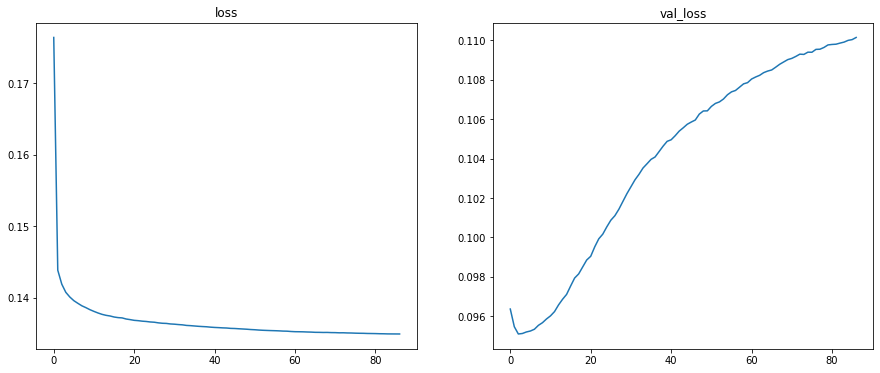

In [ ]:
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "model_10"
path_model_dir = path_models / model_name
if path_model_dir.is_dir():
    shutil.rmtree(path_model_dir)
path_model_ckpts = path_models / "weights_checkpoints"

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    # initial_epoch=3,
    verbose=2,
    batch_size=batch_size,
    # shuffle=False,
    callbacks=[
        TqdmCallback(verbose=2),
        EarlyStopping(monitor='loss', min_delta=1e-4, patience=10),
        ModelCheckpoint(
            filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}_val_loss_{val_loss:.4f}.hdf5",
            # filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}.hdf5",
            verbose=0, save_best_only=False,
            save_weights_only=True, mode='auto', save_freq="epoch",
            options=None
        )
    ],
)

# save model
print("saving model ...")
model.save(path_model_dir)
print("done")

# save fit history
joblib.dump(history.history, path_model_dir / "fit_history.pkl")

# save model png representation
path_model_png_file = path_model_dir / "model.png"
plot_model(model, to_file=str(path_model_png_file), show_shapes=True, rankdir="TB")

# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(history.history["loss"])), history.history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

## test the model

In [ ]:
# load model
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "model_03"
model = keras.models.load_model(path_models / model_name)

# load fit history
fit_history = joblib.load(path_models / model_name / "fit_history.pkl")

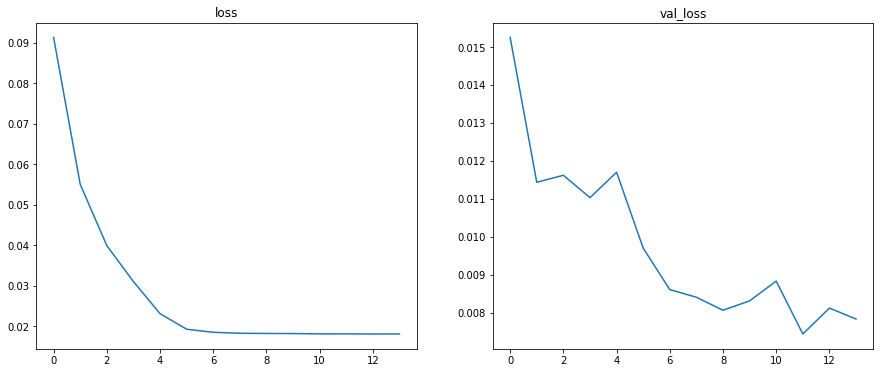

In [ ]:
# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(fit_history["loss"])), fit_history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(fit_history["val_loss"])), fit_history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
index_split

2218

In [ ]:
df.loc[2218, "timestamp"]

Timestamp('2018-01-27 00:00:00')

In [ ]:
df_train

,timestamp,coal
0,2012-01-01,2.448325e+06
1,2012-01-02,2.938653e+06
2,2012-01-03,4.430877e+06
3,2012-01-04,4.903744e+06
4,2012-01-05,4.765032e+06
...,...,...
2213,2018-01-22,3.730270e+05
2214,2018-01-23,1.297260e+05
2215,2018-01-24,3.655580e+05
2216,2018-01-25,4.875140e+05


In [ ]:
df_test

,timestamp,coal
1940,2017-04-24,133306.000000
1941,2017-04-25,203597.874126
1942,2017-04-26,293837.000000
1943,2017-04-27,212568.000000
1944,2017-04-28,245251.000000
...,...,...
2767,2019-07-30,0.000000
2768,2019-07-31,0.000000
2769,2019-08-01,0.000000
2770,2019-08-02,0.000000


In [ ]:
# batch = scaled_train[-input_length:].reshape((1, input_length, 1))
for _ in range(10):
    batch = np.random.uniform(low=0, high=10, size=input_length).reshape((1, input_length, 1))
    print(model.predict(batch))
    print()

[[0.62716216 0.6183185  0.63008887 0.63590664 0.61301064 0.61333674
  0.63363    0.6359559  0.63220924 0.6261301  0.6329912  0.6333652
  0.6356806  0.62444556 0.6312593  0.63555986 0.631626   0.6315019
  0.6316703  0.6362878  0.6151095  0.6320941  0.6378101  0.6298708
  0.6374333  0.6322076  0.6222291  0.6337358  0.633909   0.63324237]]

[[0.62711215 0.6183296  0.63005304 0.6359235  0.6129818  0.6133744
  0.6336561  0.63595486 0.6321727  0.6261571  0.6329818  0.63337576
  0.63568646 0.6245234  0.63123906 0.63555443 0.63160664 0.63149583
  0.63167626 0.6363172  0.6150841  0.63212115 0.63780105 0.62982756
  0.6374527  0.6321427  0.62221754 0.633796   0.633885   0.63326514]]

[[0.62714726 0.61832273 0.6300773  0.63591045 0.6130025  0.6133488
  0.6336369  0.63595444 0.6321983  0.626138   0.6329886  0.63336724
  0.6356809  0.6244682  0.6312534  0.6355581  0.6316202  0.63149965
  0.63167113 0.6362954  0.6151032  0.6321023  0.6378062  0.6298579
  0.6374378  0.63218814 0.6222264  0.6337534  0.

**pred n_lag by n_lag**

In [ ]:
test_predictions = []
first_batch_for_prediction = scaled_train[-input_length:]
current_batch = first_batch_for_prediction.reshape((1, input_length, 1))
print(current_batch.shape)
print(current_batch)

for index in tqdm(range(0, len(df_test), output_length)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions += list(current_prediction)
    # current_batch = current_prediction.reshape((1, input_length, 1))
    if input_length > output_length:
        n_elements_to_keep = input_length - output_length
        current_batch[0, :n_elements_to_keep, 0] = current_batch[0, -n_elements_to_keep:, 0]
        current_batch[0, -output_length:, 0] = current_prediction
    else:
        current_batch = current_prediction[-input_length:].reshape((1, input_length, 1))
        print(current_batch)

test_predictions = np.array(test_predictions).reshape((-1, 1))
test_predictions_unnormalized = scaler.inverse_transform(test_predictions)
df_test["predictions"] = test_predictions_unnormalized[:len(df_test)]

(1, 30, 1)
[[[0.60797048]
  [0.60872651]
  [0.60865486]
  [0.63943211]
  [0.65699041]
  [0.66041903]
  [0.65944535]
  [0.65962223]
  [0.65956244]
  [0.66067885]
  [0.60308536]
  [0.55916484]
  [0.57090117]
  [0.5478986 ]
  [0.46554335]
  [0.47784219]
  [0.4727689 ]
  [0.52919787]
  [0.53352048]
  [0.52888648]
  [0.59505689]
  [0.63637246]
  [0.64090333]
  [0.63976626]
  [0.59477898]
  [0.50338074]
  [0.45898209]
  [0.47968006]
  [0.52624738]
  [0.53318565]]]


  0%|          | 0/28 [00:00<?, ?it/s]

[[[0.6270211 ]
  [0.6183446 ]
  [0.62999374]
  [0.6359569 ]
  [0.6129318 ]
  [0.61343735]
  [0.633705  ]
  [0.6359608 ]
  [0.63211393]
  [0.62620294]
  [0.63296974]
  [0.6333918 ]
  [0.63569874]
  [0.6246522 ]
  [0.6312075 ]
  [0.6355523 ]
  [0.6315715 ]
  [0.6314896 ]
  [0.6316902 ]
  [0.6363689 ]
  [0.61503285]
  [0.63216895]
  [0.6377909 ]
  [0.62975645]
  [0.63749194]
  [0.63203424]
  [0.62220037]
  [0.6339039 ]
  [0.63384223]
  [0.6333052 ]]]
[[[0.6270301 ]
  [0.6183436 ]
  [0.62999934]
  [0.6359537 ]
  [0.61293656]
  [0.61343056]
  [0.6337    ]
  [0.6359606 ]
  [0.63212025]
  [0.6261982 ]
  [0.63297194]
  [0.6333896 ]
  [0.63569707]
  [0.6246389 ]
  [0.6312114 ]
  [0.6355535 ]
  [0.63157505]
  [0.6314902 ]
  [0.6316885 ]
  [0.6363635 ]
  [0.61503816]
  [0.6321644 ]
  [0.63779163]
  [0.62976354]
  [0.637488  ]
  [0.6320453 ]
  [0.6222023 ]
  [0.6338932 ]
  [0.6338463 ]
  [0.6333016 ]]]
[[[0.6270301 ]
  [0.6183436 ]
  [0.62999934]
  [0.6359537 ]
  [0.61293656]
  [0.61343056]
  [0.6

In [ ]:
df_test

,timestamp,nuclear,predictions
1940,2017-04-24,1.985808e+06,2127018.50
1941,2017-04-25,1.941438e+06,2114061.75
1942,2017-04-26,1.904044e+06,2131457.50
1943,2017-04-27,1.975130e+06,2140362.25
1944,2017-04-28,2.010716e+06,2105978.75
...,...,...,...
2767,2019-07-30,1.573999e+06,2133692.25
2768,2019-07-31,1.606865e+06,2133988.25
2769,2019-08-01,1.606940e+06,2140969.50
2770,2019-08-02,1.592180e+06,2109124.25


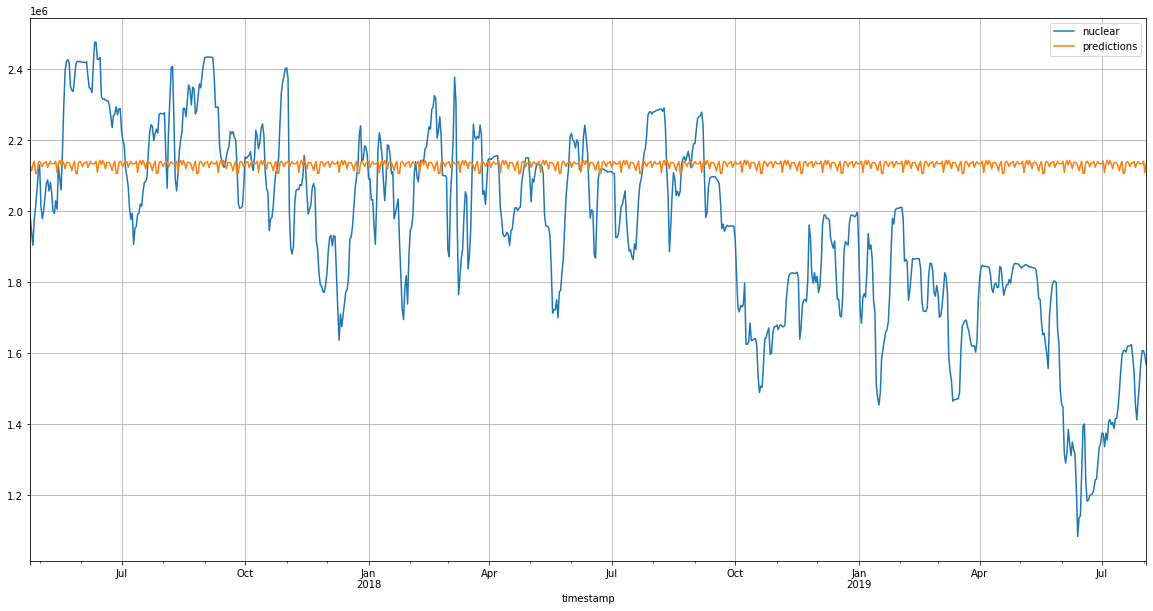

In [ ]:
df_test.set_index(keys="timestamp").plot(figsize=(20,10), grid=True)

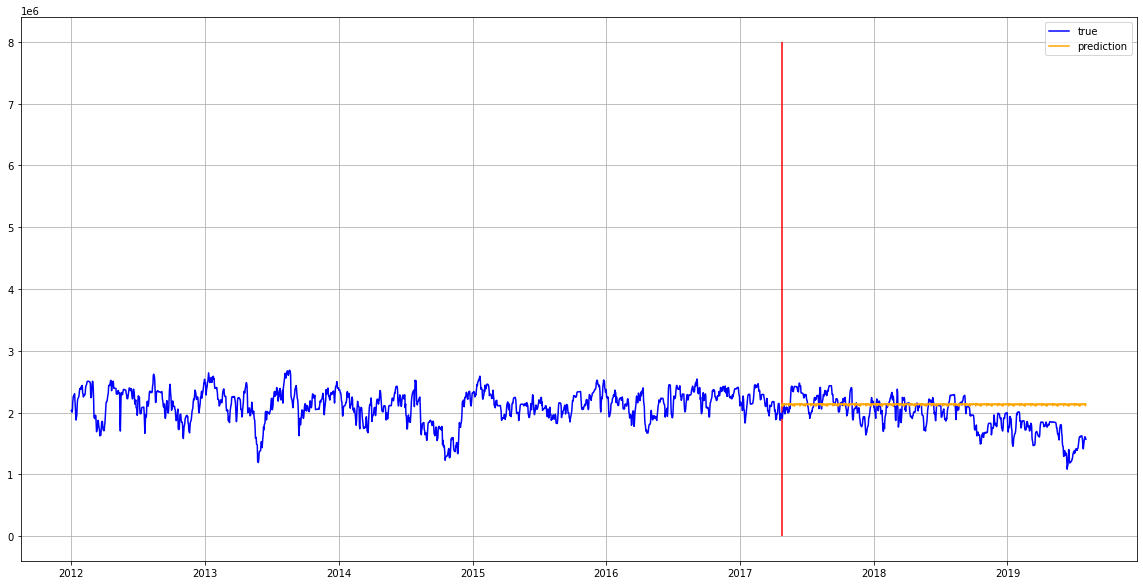

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.vlines(x=df.loc[index_split, "timestamp"], ymin=0, ymax=8000000, colors='r')

ax.plot(df["timestamp"].values, df["nuclear"].values, 'b', label="true")
ax.plot(df_test["timestamp"].values, df_test["predictions"].values, "orange", label="prediction")

plt.grid()
plt.legend()
plt.show()

In [ ]:
ax

# THEO TROP FORT

In [ ]:
generate_df_by_time_section?

In [ ]:
df = generate_df_by_time_section(time_section="day", verbose=True)[["timestamp", "nuclear"]].set_index("timestamp")
df

replace outliers in 'solar' values with interpolation ...
set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


,nuclear
timestamp,
2012-01-01,2.029537e+06
2012-01-02,2.037884e+06
2012-01-03,2.005847e+06
2012-01-04,2.039013e+06
2012-01-05,2.171748e+06
...,...
2019-07-30,1.573999e+06
2019-07-31,1.606865e+06
2019-08-01,1.606940e+06


In [ ]:
# Divide data into train and test sets
train_split_percent = 0.75

train_split_percent = int(df.shape[0] * train_split_percent)

train = df.iloc[:train_split_percent]
test = df.iloc[train_split_percent:]

# Normalize training data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
 
# Create supervised data with 12 inputs and 1 output
n_lag = 30
n_output = 30
X_train = []
y_train = []
for i in range(n_lag, len(train) - n_lag):
    X_train.append(train_scaled[i-n_lag:i, 0])
    y_train.append(train_scaled[i:i+n_output, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Reshape train set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 30)            60        
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 256)           293888    
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 30)                1950      
Total params: 542,426
Trainable params: 542,426
Non-trainable params: 0
_______________________________________________________

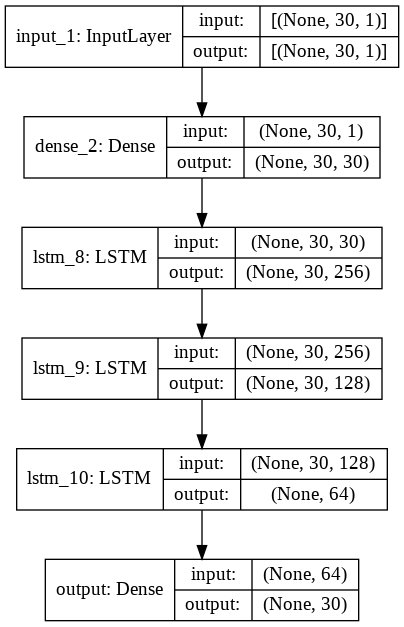

In [ ]:
inputs = Input(shape=(X_train.shape[1], 1))

main = Dense(n_lag, activation="relu")(inputs)

main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(256, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
main = LSTM(128, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)(main)
# main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)
# main = LSTM(128, activation="tanh", recurrent_activation="sigmoid")(main)
# main = TCN()(main)
main = LSTM(64, activation="tanh", recurrent_activation="sigmoid")(main)

main = Dense(n_output, activation=None, name='output')(main)

model = Model(inputs, main)

model.summary()

model.compile(
  optimizer = Adam(learning_rate=0.001),
  loss = "mae",
)
plot_model(model, to_file="blbl.png", show_shapes=True)

0epoch [00:00, ?epoch/s]

Epoch 1/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 10s - loss: 0.1564 - val_loss: 0.1099
Epoch 2/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1253 - val_loss: 0.0847
Epoch 3/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1202 - val_loss: 0.0881
Epoch 4/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1164 - val_loss: 0.0900
Epoch 5/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1140 - val_loss: 0.0822
Epoch 6/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1138 - val_loss: 0.0893
Epoch 7/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1120 - val_loss: 0.0775
Epoch 8/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1110 - val_loss: 0.0840
Epoch 9/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1097 - val_loss: 0.0773
Epoch 10/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1094 - val_loss: 0.0821
Epoch 11/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1087 - val_loss: 0.0783
Epoch 12/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1072 - val_loss: 0.0802
Epoch 13/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1065 - val_loss: 0.0873
Epoch 14/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1068 - val_loss: 0.0882
Epoch 15/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1054 - val_loss: 0.0857
Epoch 16/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1062 - val_loss: 0.0828
Epoch 17/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1046 - val_loss: 0.0927
Epoch 18/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1053 - val_loss: 0.0800
Epoch 19/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1044 - val_loss: 0.0807
Epoch 20/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1037 - val_loss: 0.0802
Epoch 21/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1020 - val_loss: 0.0795
Epoch 22/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.1014 - val_loss: 0.0910
Epoch 23/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0991 - val_loss: 0.0881
Epoch 24/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0994 - val_loss: 0.0915
Epoch 25/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0992 - val_loss: 0.0852
Epoch 26/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0989 - val_loss: 0.0885
Epoch 27/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0999 - val_loss: 0.0825
Epoch 28/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0986 - val_loss: 0.0910
Epoch 29/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0977 - val_loss: 0.0921
Epoch 30/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0972 - val_loss: 0.0893
Epoch 31/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0935 - val_loss: 0.0982
Epoch 32/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0922 - val_loss: 0.0814
Epoch 33/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0910 - val_loss: 0.0862
Epoch 34/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0892 - val_loss: 0.0868
Epoch 35/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0889 - val_loss: 0.0876
Epoch 36/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0923 - val_loss: 0.0862
Epoch 37/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0854 - val_loss: 0.0985
Epoch 38/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0813 - val_loss: 0.0957
Epoch 39/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0829 - val_loss: 0.0961
Epoch 40/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0786 - val_loss: 0.0976
Epoch 41/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0735 - val_loss: 0.0899
Epoch 42/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0708 - val_loss: 0.0997
Epoch 43/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0692 - val_loss: 0.0949
Epoch 44/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0661 - val_loss: 0.1009
Epoch 45/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0643 - val_loss: 0.1044
Epoch 46/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0635 - val_loss: 0.1017
Epoch 47/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0615 - val_loss: 0.1048
Epoch 48/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0658 - val_loss: 0.1027
Epoch 49/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0563 - val_loss: 0.1003
Epoch 50/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0518 - val_loss: 0.0969
Epoch 51/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0495 - val_loss: 0.1039
Epoch 52/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0478 - val_loss: 0.1052
Epoch 53/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0485 - val_loss: 0.1050
Epoch 54/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0434 - val_loss: 0.0996
Epoch 55/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0420 - val_loss: 0.1028
Epoch 56/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0403 - val_loss: 0.1025
Epoch 57/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0385 - val_loss: 0.1042
Epoch 58/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0384 - val_loss: 0.1050
Epoch 59/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0366 - val_loss: 0.0986
Epoch 60/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0363 - val_loss: 0.1034
Epoch 61/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0346 - val_loss: 0.1052
Epoch 62/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0341 - val_loss: 0.1018
Epoch 63/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0334 - val_loss: 0.1052
Epoch 64/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0320 - val_loss: 0.1041
Epoch 65/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0311 - val_loss: 0.1022
Epoch 66/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0307 - val_loss: 0.1014
Epoch 67/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0300 - val_loss: 0.1045
Epoch 68/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0314 - val_loss: 0.1042
Epoch 69/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0299 - val_loss: 0.1013
Epoch 70/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0286 - val_loss: 0.1006
Epoch 71/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0281 - val_loss: 0.1028
Epoch 72/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0278 - val_loss: 0.1017
Epoch 73/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0271 - val_loss: 0.1037
Epoch 74/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0268 - val_loss: 0.1019
Epoch 75/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0261 - val_loss: 0.1000
Epoch 76/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0262 - val_loss: 0.1021
Epoch 77/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0255 - val_loss: 0.1003
Epoch 78/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0256 - val_loss: 0.1020
Epoch 79/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0252 - val_loss: 0.1031
Epoch 80/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0250 - val_loss: 0.1051
Epoch 81/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0242 - val_loss: 0.1034
Epoch 82/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0239 - val_loss: 0.1026
Epoch 83/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0235 - val_loss: 0.1013
Epoch 84/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0233 - val_loss: 0.1008
Epoch 85/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0230 - val_loss: 0.1011
Epoch 86/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0225 - val_loss: 0.1017
Epoch 87/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0221 - val_loss: 0.1017
Epoch 88/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0219 - val_loss: 0.1029
Epoch 89/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0218 - val_loss: 0.1008
Epoch 90/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0216 - val_loss: 0.1022
Epoch 91/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0214 - val_loss: 0.1023
Epoch 92/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0216 - val_loss: 0.0997
Epoch 93/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0213 - val_loss: 0.1015
Epoch 94/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0211 - val_loss: 0.0977
Epoch 95/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0213 - val_loss: 0.1020
Epoch 96/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0209 - val_loss: 0.1032
Epoch 97/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0204 - val_loss: 0.1019
Epoch 98/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0208 - val_loss: 0.1006
Epoch 99/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0203 - val_loss: 0.1007
Epoch 100/100


  0%|          | 0.00/101 [00:00<?, ?batch/s]

101/101 - 4s - loss: 0.0200 - val_loss: 0.1021
saving model ...


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_11/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_11/assets


done


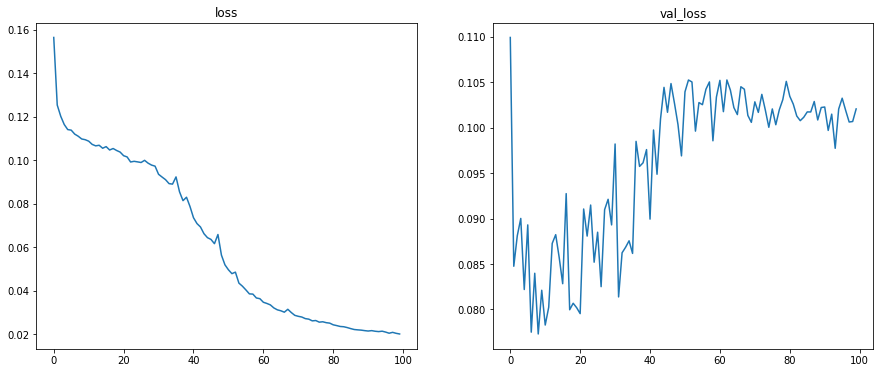

In [ ]:
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "model_11"
path_model_dir = path_models / model_name
if path_model_dir.is_dir():
    shutil.rmtree(path_model_dir)
path_model_ckpts = path_models / "weights_checkpoints"

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    verbose=2,
    batch_size=16,
    callbacks=[
        ModelCheckpoint(
            filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}_val_loss_{val_loss:.4f}.hdf5",
            # filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}.hdf5",
            verbose=0, save_best_only=False,
            save_weights_only=True, mode='auto', save_freq="epoch",
            options=None
        ),
        TqdmCallback(verbose=2)
    ]
)

# save model
print("saving model ...")
model.save(path_model_dir)
print("done")

# save fit history
joblib.dump(history.history, path_model_dir / "fit_history.pkl")

# save model png representation
path_model_png_file = path_model_dir / "model.png"
plot_model(model, to_file=str(path_model_png_file), show_shapes=True, rankdir="TB")

# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(history.history["loss"])), history.history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
predict = pd.DataFrame(test.values)
predict.columns = ["nuclear"]
predict.index = test.index
predict

,nuclear
timestamp,
2017-09-10,2.293252e+06
2017-09-11,2.293627e+06
2017-09-12,2.185045e+06
2017-09-13,2.151942e+06
2017-09-14,2.139938e+06
...,...
2019-07-30,1.573999e+06
2019-07-31,1.606865e+06
2019-08-01,1.606940e+06


(1, 30, 1)


  0%|          | 0/24 [00:00<?, ?it/s]

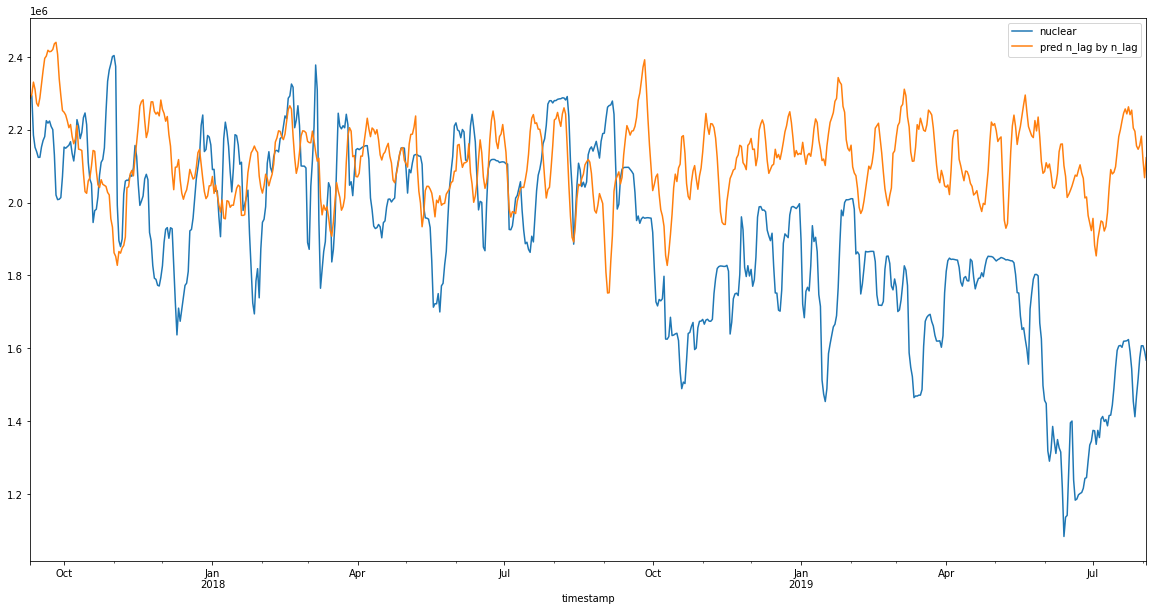

In [ ]:
test_predictions = []
first_batch_for_prediction = train_scaled[-n_lag :]
current_batch = first_batch_for_prediction.reshape((1, n_lag, 1))
print(current_batch.shape)
for index in tqdm(range(0, len(predict), n_output)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions += list(current_prediction)
    # current_batch = current_prediction.reshape((1, n_lag, 1))
    if n_lag > n_output:
        n_elements_to_keep = n_lag - n_output
        current_batch[0, :n_elements_to_keep, 0] = current_batch[0, -n_elements_to_keep:, 0]
        current_batch[0, -n_elements_to_keep:, 0] = current_prediction
    else:
        current_batch = current_prediction[-n_lag:].reshape((1, n_lag, 1))
test_predictions = np.array(test_predictions).reshape((-1, 1))
test_predictions_unnormalized = sc.inverse_transform(test_predictions)
predict["pred n_lag by n_lag"] = test_predictions_unnormalized[:len(predict)]
predict.plot(figsize=(20,10))

# Darts

In [ ]:
df_wind_day = generate_df_by_time_section(time_section="day", verbose=True)["wind"]
df_wind_day

replace outliers in 'solar' values with interpolation ...
set seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean values for every day ...
multiply all values by 12 * 24 to get the actual values by day ...
done


0       7.603880e+05
1       7.955313e+05
2       6.219160e+05
3       7.644070e+05
4       7.601810e+05
            ...     
2767    1.233718e+06
2768    1.685585e+06
2769    6.505120e+05
2770    2.959050e+05
2771    1.844990e+05
Name: wind, Length: 2772, dtype: float64

In [ ]:
df_day_wind

,timestamp,coal,nuclear,wind,hydro,solar
0,2012-01-01,2.448325e+06,2.029537e+06,7.603880e+05,226484.000000,0.000000
1,2012-01-02,2.938653e+06,2.037884e+06,7.955313e+05,224000.780488,0.000000
2,2012-01-03,4.430877e+06,2.005847e+06,6.219160e+05,231623.000000,0.000000
3,2012-01-04,4.903744e+06,2.039013e+06,7.644070e+05,232221.000000,0.000000
4,2012-01-05,4.765032e+06,2.171748e+06,7.601810e+05,238301.000000,0.000000
...,...,...,...,...,...,...
2767,2019-07-30,0.000000e+00,1.573999e+06,1.233718e+06,73637.000000,376435.335097
2768,2019-07-31,0.000000e+00,1.606865e+06,1.685585e+06,92945.000000,355390.763997
2769,2019-08-01,0.000000e+00,1.606940e+06,6.505120e+05,117124.000000,519328.582901
2770,2019-08-02,0.000000e+00,1.592180e+06,2.959050e+05,115334.000000,596295.099905


In [ ]:
darts_time_series = TimeSeries.from_dataframe(
    df=df_day,
    time_col="timestamp"
)
darts_time_series

<TimeSeries (DataArray) (timestamp: 2772, component: 5, sample: 1)>
array([[[2448325.        ],
        [2029537.        ],
        [ 760388.        ],
        [ 226484.        ],
        [      0.        ]],

       [[2938652.65505226],
        [2037883.98606272],
        [ 795531.26132404],
        [ 224000.7804878 ],
        [      0.        ]],

       [[4430877.        ],
        [2005847.        ],
        [ 621916.        ],
        [ 231623.        ],
        [      0.        ]],

       ...,

       [[      0.        ],
        [1606940.        ],
        [ 650512.        ],
        [ 117124.        ],
        [ 519328.582901  ]],

       [[      0.        ],
        [1592180.        ],
        [ 295905.        ],
        [ 115334.        ],
        [ 596295.099905  ]],

       [[      0.        ],
        [1567348.14814815],
        [ 184498.96296296],
        [  90230.51851852],
        [ 607272.59614696]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2012-01-01 2012-01-02 ... 2019-08-03
  * component  (component) object 'coal' 'nuclear' 'wind' 'hydro' 'solar'
Dimensions without coordinates: sample

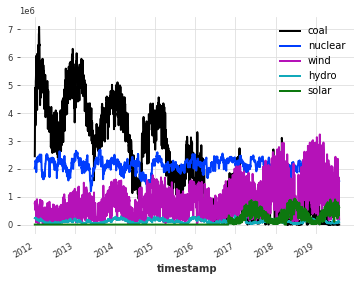

In [ ]:
darts_time_series.plot()

In [ ]:
train, val = darts_time_series.split_before(pd.Timestamp(datetime(2018, 1, 1)))
display(train, val)

<TimeSeries (DataArray) (timestamp: 2192, component: 5, sample: 1)>
array([[[2448325.        ],
        [2029537.        ],
        [ 760388.        ],
        [ 226484.        ],
        [      0.        ]],

       [[2938652.65505226],
        [2037883.98606272],
        [ 795531.26132404],
        [ 224000.7804878 ],
        [      0.        ]],

       [[4430877.        ],
        [2005847.        ],
        [ 621916.        ],
        [ 231623.        ],
        [      0.        ]],

       ...,

       [[ 607225.        ],
        [2184378.        ],
        [1765167.        ],
        [ 140265.        ],
        [  90000.05801   ]],

       [[ 365846.        ],
        [2179958.        ],
        [1720302.        ],
        [ 126988.        ],
        [  70581.944398  ]],

       [[ 345987.        ],
        [2158540.        ],
        [2354495.        ],
        [ 125264.        ],
        [  66365.001193  ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2012-01-01 2012-01-02 ... 2017-12-31
  * component  (component) object 'coal' 'nuclear' 'wind' 'hydro' 'solar'
Dimensions without coordinates: sample

<TimeSeries (DataArray) (timestamp: 580, component: 5, sample: 1)>
array([[[ 470315.        ],
        [2090746.        ],
        [2044389.        ],
        [ 132438.        ],
        [  86648.173894  ]],

       [[ 626665.        ],
        [2091409.        ],
        [1936422.        ],
        [ 126759.        ],
        [  20136.18311   ]],

       [[ 359356.        ],
        [2031068.        ],
        [2302815.        ],
        [ 136072.        ],
        [  99935.505604  ]],

       ...,

       [[      0.        ],
        [1606940.        ],
        [ 650512.        ],
        [ 117124.        ],
        [ 519328.582901  ]],

       [[      0.        ],
        [1592180.        ],
        [ 295905.        ],
        [ 115334.        ],
        [ 596295.099905  ]],

       [[      0.        ],
        [1567348.14814815],
        [ 184498.96296296],
        [  90230.51851852],
        [ 607272.59614696]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-08-03
  * component  (component) object 'coal' 'nuclear' 'wind' 'hydro' 'solar'
Dimensions without coordinates: sample

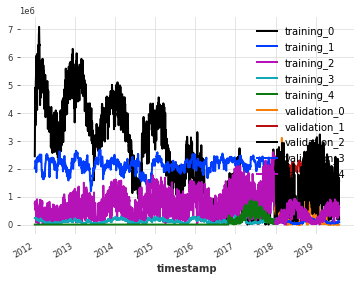

In [ ]:
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:
plot_acf(train, alpha = .05)

[2021-10-19 10:21:39,742] ERROR | darts.timeseries | AssertionError: Only univariate TimeSeries instances support this method


AssertionError: ignored

# DUMP

In [ ]:
try:
    raise ValueError
except Exception as error:
    print(type(error))

In [ ]:
a = np.array([1,2,3,4,5]).reshape(1,-1,1)
b = np.array([6,7])
a, b

(array([[[1],
         [2],
         [3],
         [4],
         [5]]]), array([6, 7]))

In [ ]:
n_elements_to_keep = a.shape[1] - b.shape[0]
a[0, :n_elements_to_keep, 0] = a[0, -n_elements_to_keep:, 0]

In [ ]:
a[0, -b.shape[0]:, 0] = b

In [ ]:
a

array([[[3],
        [4],
        [5],
        [6],
        [7]]])

In [ ]:
def find_greatest_divider(n):

    assert n > 0
    smallest_divider = 1
    greatest_divider = n

    for potential_divider in range(1, n):
        if (n % potential_divider) == 0:
            smallest_divider = potential_divider
            greatest_divider = n // potential_divider
    
    return smallest_divider, greatest_divider

find_greatest_divider(int(1793 * 0.8))

(717, 2)

In [ ]:
print("qsdmlfkjqmdfjqdsf"
"qkjdfpoqjif"
"mdfkhjqodjfùqf")

qsdmlfkjqmdfjqdsfqkjdfpoqjifmdfkhjqodjfùqf


In [ ]:
df_test = pd.DataFrame.from_dict({
    "col1": [1,1,1],
    "col2": [2,2,2],
    "col3": [3,3,3]
})
df_test

,col1,col2,col3
0,1,2,3
1,1,2,3
2,1,2,3


In [ ]:
df_test_2 = df_test[["col1", "col3"]].copy()
df_test_2

,col1,col3
0,1,3
1,1,3
2,1,3


In [ ]:
df_test_2.loc[0, "col1"] = 10
display(df_test_2, df_test)

,col1,col3
0,10,3
1,1,3
2,1,3


,col1,col2,col3
0,1,2,3
1,1,2,3
2,1,2,3
